In [22]:
# -*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Fichier contenant la représentation vectoriel de tous les documents
data_file = 'data'
# Fichier contenant le ranking sans diversité
# Ranking effectué avec un modèle vectoriel
baseline_file = 'baseline'
# Fichier générer par notre moteur de recherche, permet de récupérer les identifiants des documents
dico_file = 'easyCLEF08_text_index'
# Fichiers contenant toutes les requêtes avec les documents pertinents asssociés
rel_file = 'relevants'

### Lecture des fichiers

def get_data(n, m, path):
    X = np.zeros((n, m))
    Y = np.zeros(n)
    i = 0
    for line in open(path):
        tmp = line.split()
        j = 0
        for x in tmp[:-1]: # y en fin
            X[i][j] = float(x) 
            j+= 1
        Y[i] = tmp[-1]
        i += 1
        if i == n:
            break
    return X, Y

def get_relevants(dico, path):
    Q = {}
    f = open(path)
    for line in open(path):
        tmp = line.split()
        n = len(tmp[:-1])
        #print "nbRel Query id " + tmp[-1] + " = " + str(n)
        aux = []
        for i in range(n):
            aux.append(dico[tmp[i]])
        Q[tmp[-1]] = np.array(aux)
    return Q

def get_ranking_baseline(dico, path):
    Q = {}
    for line in open(path):
        tmp = line.split()
        n = len(tmp[:-1])
        aux = []
        for i in range(n):
            aux.append(dico[tmp[i]])
        Q[tmp[-1]] = np.array(aux)
    return Q

def get_dico(path):
    dico = {}
    cpt = 0
    for line in open(path):
        tmp = line.split(':')
        dico[tmp[0]] = cpt
        cpt += 1
    return dico




# Tous les ranking sont constitués des indices des documents dans X

### Algorithmes de diversité

# Sélectionne 'n' documents aléatoirement dans la baseline
def ranking_div_alea(baseline, n):
    return random.sample(xrange(baseline.size), n)

# Sélection aléatoire 'n' documents en alternant les clusters
def ranking_div_kmeans(baseline, n, nbClusters):
    #reduced_data = PCA(n_components=10).fit_transform(X)
    kmeans = KMeans(init='k-means++', n_clusters=nbClusters)
    #kmeans.fit(reduced_data)
    kmeans.fit(X[baseline])

    # on attribue a chaque cluster l'indice du documents X
    matching = {}
    cpt = 0
    for c in kmeans.labels_:
        if matching.has_key(c): 
            matching[c].append(baseline[cpt])
        else:
            matching[c] = [baseline[cpt]]
        cpt += 1

    #print "clusters : " +  str(kmeans.cluster_centers_.shape)

    res = []
    nlabels = kmeans.n_clusters
    tab_nsamples = np.zeros(nlabels)
    i = 0
    while True:
        for k in range(nlabels): 
            if len(matching[k]) > tab_nsamples[k]: 
                tab_nsamples[k] += 1
                i += 1
            if i >= n:
                break
        if i >= n:
            break
    for k in range(nlabels):
        res += random.sample(np.array(matching[k]), int(tab_nsamples[k]))
    return np.array(res)

# Sélection 'n' documents dans les clusters en concervant le ranking de baseline
# cad la similarité à la requête 
# Les clusters sont parcourus par rapport à la distance de leurs centres à la requête
def ranking_div_kmeans2(baseline, n, nbClusters):
    #reduced_data = PCA(n_components=500).fit_transform(X)
    kmeans = KMeans(init='k-means++', n_clusters=nbClusters)
    #kmeans.fit(reduced_data)
    kmeans.fit(X[baseline])
    
    # on attribue a chaque cluster l'indice du documents X
    matching = {}
    cpt = 0
    for c in kmeans.labels_:
        if matching.has_key(c): 
            matching[c].append(baseline[cpt])
        else:
            matching[c] = [baseline[cpt]]
        cpt += 1

    #print "clusters : " +  str(kmeans.cluster_centers_.shape)

    res = []
    nlabels = kmeans.n_clusters
    tab_nsamples = np.zeros(nlabels)
    i = 0

    ordo_cluster = []

    req = X[baseline[0]]
    dist = np.array([((c - req)**2).sum() for c in kmeans.cluster_centers_])
    dist = np.argsort(dist)

    while True:
        for k in dist:
            if len(matching[k]) > tab_nsamples[k]: # FIXME : attention !     
                tab_nsamples[k] += 1
                i += 1
            if i >= n:
                break
        if i >= n:
            break
    for k in range(nlabels):
        res += matching[k][:int(tab_nsamples[k])]
    return np.array(res)


def p_n(ranking, rel, n):
    tmp = ranking[:n]
    return sum(np.array([x in rel for x in tmp])) / float(n)

def cr_n(ranking, rel, n):
    nb_topics_q = len(np.unique(Y[rel]))
    #print "Nombre sous thème de la query : " + str(nb_topics_q)
    return (len(np.unique(Y[ranking[:n]]))) / float(nb_topics_q)

In [19]:


# n est le nombre de documents à renvoyer
n = 20
print "n = " + str(n)
# Sur combien d'éxécutions on moyenne
mean = 3
nbClusters = 18 # doit être plus petit que 'n', et plus petit que le 'nb_topics'
debug = False

nbrDoc_baseline = 200 # doit être plus grand que 184 (nbRel max des queries)




# On a 2256 documents, chaque document est représenter par un vecteur de taille 2353, 
# avec comme dernière valeur sont topic
X, Y = get_data(2256, 2354, data_file) 
nb_topics = len(np.unique(Y))
print "Nombre topics (tous documents) : " + str(nb_topics)

dico = get_dico(dico_file)
baseline = get_ranking_baseline(dico, baseline_file)
relevants = get_relevants(dico, rel_file)

n = 20
Nombre topics (tous documents) : 23


In [5]:
# Exécution

cr_mean = 0
p_mean = 0
for q in relevants.keys():
    #print "#### Query " + q
    acc1 = 0
    acc2 = 0
    #print "nombre doc dans la baseline : " + str(baseline[q].shape[0])
    for i in range(mean):
        rel = relevants[q]
        ranking = baseline[q][:nbrDoc_baseline]
        #ranking = ranking_div_alea(baseline[q][:nbrDoc_baseline], n)
        #ranking = ranking_div_kmeans2(baseline[q][:nbrDoc_baseline], n, nbClusters)
        acc1 += cr_n(ranking, rel, n)
        acc2 += p_n(ranking, rel, n)
    #print "CR = " + str(acc1 / float(mean)) + "  P = " + str(acc2 / float(mean))
    cr_mean += acc1 / float(mean)
    p_mean += acc2 / float(mean)
    if debug:
        break
print "\n===> CR Query Mean = " + str(cr_mean / len(relevants.keys())) + ", P Query Mean = " + str(p_mean / len(relevants.keys()))



===> CR Query Mean = 0.770469425904, P Query Mean = 0.597435897436


In [26]:
def getCR_P(relevants,baseline,nbrDoc_baseline,mean,n,choiceRanking,nbClusters):
    cr_mean = 0
    p_mean = 0
    for q in relevants.keys():
        acc1 = 0
        acc2 = 0
        #print "nombre doc dans la baseline : " + str(baseline[q].shape[0])
        for i in range(mean):
            rel = relevants[q]
            if(choiceRanking==1):
                ranking = baseline[q][:nbrDoc_baseline]
            if(choiceRanking==2):
                ranking = ranking_div_alea(baseline[q][:nbrDoc_baseline], n)
            if(choiceRanking==3):
                ranking = ranking_div_kmeans2(baseline[q][:nbrDoc_baseline], n, nbClusters)
            acc1 += cr_n(ranking, rel, n)
            acc2 += p_n(ranking, rel, n)
        cr_mean += acc1 / float(mean)
        p_mean += acc2 / float(mean)
        if debug:
            break
    return cr_mean/len(relevants.keys()), p_mean/len(relevants.keys())

Nombre topics (tous documents) : 23

===> CR Query Mean = 0.770469425904, P Query Mean = 0.597435897436

===> CR Query Mean = 0.855239486761, P Query Mean = 0.412820512821

===> CR Query Mean = 0.884185232374, P Query Mean = 0.371794871795

===> CR Query Mean = 0.870751685244, P Query Mean = 0.320085470085

===> CR Query Mean = 0.918772143048, P Query Mean = 0.302136752137

===> CR Query Mean = 0.952585927224, P Query Mean = 0.32735042735

===> CR Query Mean = 0.971080221443, P Query Mean = 0.299145299145

===> CR Query Mean = 0.967381451077, P Query Mean = 0.32264957265

===> CR Query Mean = 1.00884547551, P Query Mean = 0.303846153846

===> CR Query Mean = 1.02486237595, P Query Mean = 0.266666666667

===> CR Query Mean = 1.03241075886, P Query Mean = 0.281196581197

===> CR Query Mean = 1.06565392471, P Query Mean = 0.282051282051

===> CR Query Mean = 1.09071980086, P Query Mean = 0.29188034188

===> CR Query Mean = 1.09004910817, P Query Mean = 0.287606837607

===> CR Query Mean =

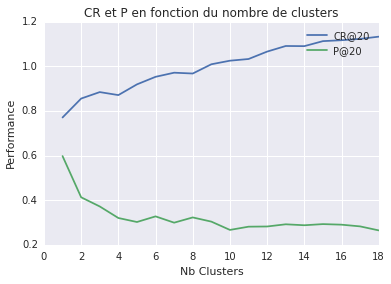

In [28]:
##parameters
n = 20
mean = 3
debug = False
nbrDoc_baseline = 200 # doit être plus grand que 184 (nbRel max des queries)


# On a 2256 documents, chaque document est représenter par un vecteur de taille 2353, 
# avec comme dernière valeur sont topic
X, Y = get_data(2256, 2354, data_file) 
nb_topics = len(np.unique(Y))
print "Nombre topics (tous documents) : " + str(nb_topics)

dico = get_dico(dico_file)
baseline = get_ranking_baseline(dico, baseline_file)
relevants = get_relevants(dico, rel_file)


tabCr=[]
tabP=[]
tabNbClusters=np.arange(1,19)
choiceRanking=3
for nbC in tabNbClusters:
    cr ,p = getCR_P(relevants,baseline,nbrDoc_baseline,mean,n,choiceRanking,nbC)
    tabCr.append(cr)
    tabP.append(p)
    
plt.plot(tabNbClusters,tabCr, label = "CR@20")
plt.plot(tabNbClusters,tabP, label = "P@20")
plt.xlabel("Nb Clusters")
plt.ylabel(u"Performance")
plt.title(u"CR et P en fonction du nombre de clusters")
plt.legend()
plt.show()


In [13]:
print(np.arange(1,19))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [ ]:
def sim_psi(u,q,ranking):
    
def sim_sigma(du,q,relevants):
    
    
def value(du,q,ranking,alpha,relevants):
    sim_s = sim_sigma(du,q,relevants)
    sim_p = sim_psi(u,q,ranking)
    return np.array([du,alpha*sim_sig-(1-alpha)*sim_p])
            
def gluttony(u,k,q,relevants,alpha=0.5):
    ranking=[]
    for i in k:
        #val sous forme np.array([np.array([idDoc,score]])
        val = np.array([value(du,q,ranking,alpha,relevants) for du in u])
        argmax = val[:,1].argmax()
        di=val[argmax][0]
        ranking.append(di)
        u=u.remove(di)
    

In [34]:
a=[np.array(['a',1]),np.array(['v',2])]

argmax = np.array(a)[:,1].argmax()

1

{'23994': 1121,
 '16079': 837,
 '23993': 1120,
 '22466': 1062,
 '4027': 139,
 '4022': 138,
 '35783': 1591,
 '35780': 1589,
 '22665': 1067,
 '11549': 671,
 '35788': 1592,
 '35789': 1593,
 '37531': 1795,
 '11384': 654,
 '10896': 619,
 '39102': 2034,
 '16671': 863,
 '19374': 970,
 '32656': 1517,
 '30449': 1317,
 '12707': 710,
 '37730': 1849,
 '12708': 711,
 '22004': 1049,
 '10965': 622,
 '6795': 317,
 '13606': 742,
 '37735': 1851,
 '13609': 743,
 '25664': 1177,
 '25661': 1176,
 '22669': 1068,
 '26485': 1201,
 '30667': 1344,
 '40357': 2228,
 '13546': 736,
 '13547': 737,
 '16709': 864,
 '17382': 893,
 '17387': 895,
 '17385': 894,
 '19575': 978,
 '16384': 849,
 '9529': 529,
 '22908': 1078,
 '7866': 397,
 '21615': 1044,
 '40213': 2201,
 '16819': 868,
 '4812': 226,
 '4815': 227,
 '17876': 908,
 '6379': 298,
 '11614': 675,
 '9413': 521,
 '10639': 599,
 '10636': 598,
 '26028': 1184,
 '6376': 297,
 '39694': 2141,
 '10140': 571,
 '39696': 2143,
 '37411': 1755,
 '39693': 2140,
 '20528': 1008,
 '119